In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook

## Complex NAC Layer

$y=\exp [W(\log(|x|+\varepsilon))]$

In [3]:
# Define a complex NAC in log space
# Usefulfor more complex arithmetic functions such as multiplication, division and power

def nac_complex_single_layer(x_in, out_units, epsilon = 0.000001):
    '''
    Attributes
    -----------
    x_in -> Input tensor
    out_units -> number of output units

    Return
    -------
    y_out -> Output tensor of mentioned shape
    W -> Weight matrix of the layer
    '''
    
    # Get the number of input features (numbers)
    in_features = x_in.shape[1]

    # random initialier
    x = tf.initializers.RandomUniform(minval=-2, maxval=2)
    
    # defining W_hat and M_hat
    W_hat = tf.Variable(shape=[in_features, out_units],
                        initial_value=x.__call__(shape=[in_features, out_units]), 
                        trainable=True, name="W_hat")

    M_hat = tf.Variable(shape=[in_features, out_units],
                        initial_value=x.__call__(shape=[in_features, out_units]), 
                        trainable=True, name="M_hat")
    
    # Weight Matrix (W) -> restricted to [-1, 1]
    W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 

    # Express input feature in log space to learn complex functions
    x_modified = tf.log(tf.abs(x_in) + epsilon)

    y = tf.exp( tf.matmul(x_modified, W) )

    return y, W

## Neural Arithmetic Logic Unit (NALU)

NALU combines Simple NAC & Complex NAC to perform any type of arithmetic operation. NALU comprises the weighted combination of a simple NAC and a complex NAC mentioned above, controlled by a learned gate signal.

$$y = g*a+(1-g)*m$$
where,
$a = Wx$

$m = \exp [W(\log(|x|+\varepsilon))]$

$W= \tanh(\hat{W})\odot \sigma (\hat{M})$

$g = sigmoid(Gx)$, G is a trainable parameter

In [4]:
def nalu(x_in, out_units, epsilon=0.000001, get_weights=False):
    '''
    Attributes
    -----------
    x_in -> Input tensor
    out_units -> number of output units

    Return
    -------
    y_out -> Output tensor of mentioned shape
    '''

    in_features = x_in.shape[1]

    # get the output tensor from simple NAC
    a, W_simple = nac_simple_single_layer(x_in, out_units)

    # get the output tensor from complex NAC
    m, W_complex = nac_complex_single_layer(x_in, out_units, epsilon= epsilon)
    
    # In the paper, the authors use the same weights for complex as well as 
    # simple NAC i.e W_simple = W_complex
    
    # random initialier
    x = tf.initializers.RandomUniform(minval=-2, maxval=2)

    # gate signal layer
    G = tf.Variable(shape=[in_features, out_units],
                    initial_value=x.__call__(shape=(2, 2)),
                    trainable=True, name="Gate_weights")

    g = tf.nn.sigmoid(tf.matmul(x_in, G))

    y_out = g * a + (1 - g) * m

    return y_out

## Simple NAC

Here, I test on addition operation using simple NAC

**Creating training data**

In [5]:
# Generate a series of input number X1 and X2 for training
x1 = np.arange(0,10000,5, dtype=np.float32)
x2 = np.arange(5,10005,5, dtype=np.float32)

In [6]:
y_train = x1 + x2

In [7]:
y_train.dtype

dtype('float32')

In [8]:
x_train = np.column_stack((x1,x2))

In [9]:
print(x_train.shape)
print(y_train.shape)

(2000, 2)
(2000,)


**Creating testing data**

In [10]:
# Generate a series of input number X1 and X2 for testing
x1 = np.arange(1000,2000,8, dtype=np.float32)
x2 = np.arange(1000,1500,4, dtype= np.float32)

In [11]:
x_test = np.column_stack((x1,x2))
y_test = x1 + x2

In [12]:
print(x_test.shape)
print(y_test.shape)

(125, 2)
(125,)


**Loss Function**

In [13]:
def loss(predicted_y, target_y):
    predicted_y = tf.squeeze(predicted_y)
    return tf.reduce_mean(tf.square(predicted_y - target_y))

**Simple Neural Accumulator (NAC) Layer**

$W= \tanh(\hat{W})\odot \sigma (\hat{M})$

In [23]:
n_epochs = 20000
alpha = 0.1

In [24]:
W_hat = tf.Variable(shape=[2, 1],
                        initial_value=tf.random.uniform(shape=[2, 1], minval=-2, maxval=2),
                        trainable=True, name="W_hat")
M_hat = tf.Variable(shape=[2, 1],
                        initial_value=tf.random.uniform(shape=[2, 1], minval=-2, maxval=2),
                        trainable=True, name="M_hat")

In [25]:
optimize = tf.keras.optimizers.Adam(learning_rate=alpha)

In [26]:
W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
y_pred = tf.matmul(x_train, W)
print(f"Initial Loss: {loss(y_pred, y_train)}")

Initial Loss: 264138736.0


In [27]:
loss_history = []

In [28]:
def train(X, y, learning_rate=0.01):
    with tf.GradientTape() as t:
        # update weight matrix (W) -> restricted to [-1, 1]
        W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
        # make prediction
        y_pred = tf.matmul(X, W)
        # calculate loss
        current_loss = loss(y_pred, y)
    dW_hat, dM_hat = t.gradient(current_loss, (W_hat, M_hat))
    optimize.apply_gradients(zip([dW_hat, dM_hat], [W_hat, M_hat]))
    return current_loss

**Looping**

In [29]:
y_train = y_train.astype('float32')

In [30]:
for epoch in range(n_epochs):
    current_loss = train(x_train, y_train)
    loss_history.append(current_loss)
    if epoch%500==0:
        print(f"Epoch: {epoch}\tLoss: {current_loss:.2f}")

Epoch: 0	Loss: 264138736.00
Epoch: 500	Loss: 67368.75
Epoch: 1000	Loss: 23683.92
Epoch: 1500	Loss: 12110.54
Epoch: 2000	Loss: 7242.39
Epoch: 2500	Loss: 4714.86
Epoch: 3000	Loss: 3233.80
Epoch: 3500	Loss: 2295.61
Epoch: 4000	Loss: 1669.04
Epoch: 4500	Loss: 1234.37
Epoch: 5000	Loss: 924.35
Epoch: 5500	Loss: 698.55
Epoch: 6000	Loss: 531.64
Epoch: 6500	Loss: 406.71
Epoch: 7000	Loss: 312.39
Epoch: 7500	Loss: 240.66
Epoch: 8000	Loss: 185.86
Epoch: 8500	Loss: 143.83
Epoch: 9000	Loss: 111.43
Epoch: 9500	Loss: 86.43
Epoch: 10000	Loss: 67.10
Epoch: 10500	Loss: 52.14
Epoch: 11000	Loss: 40.52
Epoch: 11500	Loss: 31.52
Epoch: 12000	Loss: 24.51
Epoch: 12500	Loss: 19.06
Epoch: 13000	Loss: 14.84
Epoch: 13500	Loss: 11.54
Epoch: 14000	Loss: 8.99
Epoch: 14500	Loss: 7.00
Epoch: 15000	Loss: 5.44
Epoch: 15500	Loss: 4.24
Epoch: 16000	Loss: 3.30
Epoch: 16500	Loss: 2.57
Epoch: 17000	Loss: 2.00
Epoch: 17500	Loss: 1.56
Epoch: 18000	Loss: 1.21
Epoch: 18500	Loss: 0.94
Epoch: 19000	Loss: 0.73
Epoch: 19500	Loss: 0.57

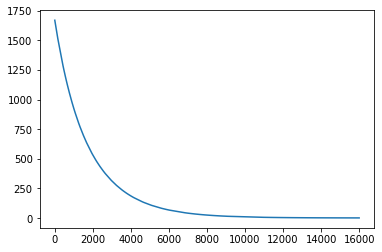

In [36]:
plt.plot(loss_history[4000:])

**Testing**

In [56]:
W = tf.nn.tanh(W_hat) * tf.nn.sigmoid(M_hat) 
y_pred = tf.matmul(x_test, W)
current_loss = loss(y_pred, y_test)

In [59]:
x_test[10]

array([1080., 1040.], dtype=float32)

In [61]:
tf.matmul([x_test[10]], W)

<tf.Tensor: id=1719718, shape=(1, 1), dtype=float32, numpy=array([[2119.878]], dtype=float32)>

In [62]:
y_test[10]

2120.0

In [70]:
for i in range(len(x_test))[:100]:
    print(f"Input: {x_test[i]}\tOutput: {tf.matmul([x_test[i]], W)[0][0]:.2f}\tActual: {y_test[i]}")

Input: [1000. 1000.]	Output: 1999.88	Actual: 2000.0
Input: [1008. 1004.]	Output: 2011.88	Actual: 2012.0
Input: [1016. 1008.]	Output: 2023.88	Actual: 2024.0
Input: [1024. 1012.]	Output: 2035.88	Actual: 2036.0
Input: [1032. 1016.]	Output: 2047.88	Actual: 2048.0
Input: [1040. 1020.]	Output: 2059.88	Actual: 2060.0
Input: [1048. 1024.]	Output: 2071.88	Actual: 2072.0
Input: [1056. 1028.]	Output: 2083.88	Actual: 2084.0
Input: [1064. 1032.]	Output: 2095.88	Actual: 2096.0
Input: [1072. 1036.]	Output: 2107.88	Actual: 2108.0
Input: [1080. 1040.]	Output: 2119.88	Actual: 2120.0
Input: [1088. 1044.]	Output: 2131.88	Actual: 2132.0
Input: [1096. 1048.]	Output: 2143.88	Actual: 2144.0
Input: [1104. 1052.]	Output: 2155.88	Actual: 2156.0
Input: [1112. 1056.]	Output: 2167.88	Actual: 2168.0
Input: [1120. 1060.]	Output: 2179.88	Actual: 2180.0
Input: [1128. 1064.]	Output: 2191.87	Actual: 2192.0
Input: [1136. 1068.]	Output: 2203.87	Actual: 2204.0
Input: [1144. 1072.]	Output: 2215.87	Actual: 2216.0
Input: [1152

In [69]:
for i in range(10):
    print(f"Input: {x_train[i]}\tOutput: {tf.matmul([x_train[i]], W)[0][0]:.2f}\tActual: {y_train[i]}")

Input: [0. 5.]	Output: 5.00	Actual: 5.0
Input: [ 5. 10.]	Output: 15.00	Actual: 15.0
Input: [10. 15.]	Output: 25.00	Actual: 25.0
Input: [15. 20.]	Output: 35.00	Actual: 35.0
Input: [20. 25.]	Output: 45.00	Actual: 45.0
Input: [25. 30.]	Output: 55.00	Actual: 55.0
Input: [30. 35.]	Output: 65.00	Actual: 65.0
Input: [35. 40.]	Output: 75.00	Actual: 75.0
Input: [40. 45.]	Output: 84.99	Actual: 85.0
Input: [45. 50.]	Output: 94.99	Actual: 95.0
